<h1> Data Spaces' Tesina <h1>

<p>Imports section<p>

In [22]:
import numpy as np
import pandas as pd
import seaborn as sn
import scipy as sp
from imblearn.over_sampling import SMOTE
from sklearn import neighbors, model_selection, metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from scipy import stats
from scipy.spatial.distance import mahalanobis

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Check class balance function

In [0]:
def checkClassBalance(data_tgt):
  class1 = data_tgt[data_tgt == 2]
  class2 = data_tgt[data_tgt == 4]
  plt.hist(class1, color='blue', width=0.5)
  plt.hist(class2, color='green', width=0.5)
  plt.show()
  print("Percentage of 2 and 4 are: ", class1.shape[0]/data_tgt.shape[0]*100, "% and ", class2.shape[0]/data_tgt.shape[0]*100,"%")

Find and remove outliers using Malahanobis Distance functions
Apply this function just to the Training set.

In [0]:
def mahalanobisDist(X,meanCol,IC):
  # calculate Mahalanobis distance for each row of the dataset
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

def detectOutliersMD(MD, data, extreme=False):
  std = np.std(MD)

  # I'll use te 68-95-99.7 rule to detect outliers

  k = 3. *std if extreme else 2. * std
  m = np.mean(MD)
  up_t = m+k
  low_t = m-k 

  outliers = []

  for i in range(len(MD)):
    if (MD[i] >= up_t or MD[i] <= low_t):
      outliers.append(i) #index
  return np.array(outliers)

def detectAndDeleteOutliers(data, tgt):

  Sx = data.cov().values
  Sx = sp.linalg.inv(Sx)

  mean = data.mean().values

  mR = mahalanobisDist(data,mean,Sx)

  outliers = detectOutliersMD(mR, x)

  cleanDs = data.reset_index(drop=True)
  cleanTgt = tgt.reset_index(drop=True)

#  for o in outliers:
  cleanDs = cleanDs.drop(index=outliers)
  cleanTgt = cleanTgt.drop(index=outliers)

  print("Dataset size before OD: ", data.shape[0], " dataset size after OD: ", cleanDs.shape[0])

  return cleanDs, cleanTgt


<p> Read .csv file <p>

In [0]:
filename = "https://raw.githubusercontent.com/Vaelthur/DataSpaces_Tesina/master/breast-cancer-wisconsin.data"


data = pd.read_csv(filename)

labels = ["Sample Number","Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", 
"Mitoses", "Class"]

# assing labels to columns
data.columns = labels

# records with the classification as "2" are Benign cancer, "2" means malign Cancer.

Detecting if there are any missing value 

In [26]:
print("Raw data as taken from repo:")
print(data.shape)
data = (data.drop(labels,axis=1)).join(data[labels].apply(pd.to_numeric, errors='coerce'))
data = data[data[labels].notnull().all(axis=1)]
print("\nData without null values")
print(data.shape)

# remove first column as it is just sample number that identify the patient
data = data.iloc[:, 1:11]
print("\nData without first Column \"Sample Number\"")
print(data.shape)

# data without classification - needed for outlier detection
x = data.iloc[:, 0:9]

Raw data as taken from repo:
(698, 11)

Data without null values
(682, 11)

Data without first Column "Sample Number"
(682, 10)


As stated in the dataset description there should have been some missing values, denoted by the non numerical value '?'. Knowing this I have been able to perform the search for missing value just looking for non-numerical values and (since there were just 16) dropping the corresponding rows. 

Observing the percentage of the two classes we can identify this dataset as imbalanced since the two classes go over the 60/40 ratio so it's not acceptable and we need to provide some more balance i.e.
- stratifying when splitting into train and test
- using library to artificially generate data to balance class, but new data must only be used during the training process and not during validation or test phases.

<p>Correlation Matrix to study correlation between data.</p>

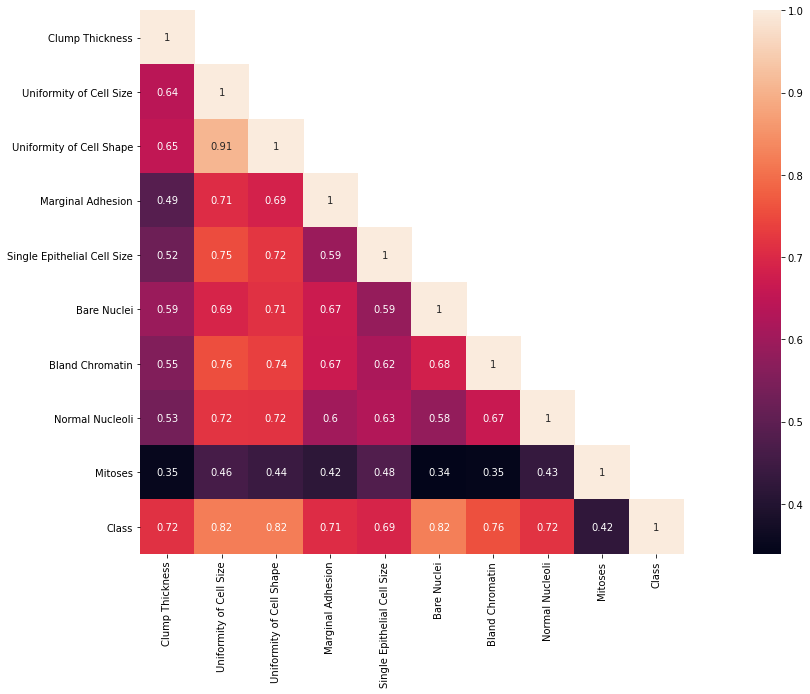

In [27]:
cm = data.corr() # Compute pairwise correlation of columns
mask = np.array(cm)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(25,10)
sn.heatmap(data=cm, mask=mask, square=True, annot=True, cbar=True)

We can observe that the correlation coefficient with any feaure aren't that good respect to the label. In this way we are going to see which features are more correlated with each other respect to others. We can observe from here that Uniformity of cell size and uniformity of cell shape features are highly correlated so we can drop one.

In [0]:
data.drop('Uniformity of Cell Size', axis=1, inplace=True)

Pairwise plot of class distinction

In [0]:
sn.pairplot(data, hue='Class')

Reading the dataset escription and observing the values inside it we can see that every feature is already scaled ina reange between 1 and 10, so we can affirm that data is already scaled because we have the same scale for each feature.

Knowing this, the <b>preprocessing</b> phase consist just in the split between train and Test sets and the further Train set balancing.

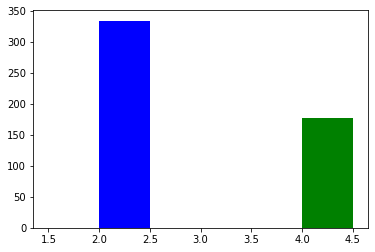

Percentage of 2 and 4 are:  65.36203522504891 % and  34.63796477495107 %
Dataset size before OD:  511  dataset size after OD:  481


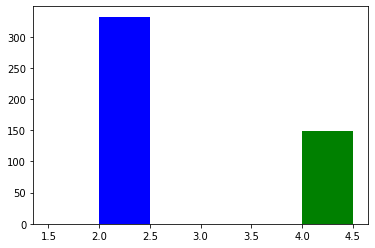

Percentage of 2 and 4 are:  69.02286902286903 % and  30.97713097713098 %


In [29]:
Y = data.iloc[:, 8]
X = data.iloc[:, 0:8]

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state=np.random.randint(0,100), test_size=0.25, shuffle=True)

checkClassBalance(Y_train)

# edit function in order to get back also outliers and add them to test ds
X_train, Y_train = detectAndDeleteOutliers(X_train, Y_train)

checkClassBalance(Y_train)

Now that I have observed the difference in distribution between the two classes in my training set I have two options: I can either undersample my dataset or artifically augment it in order to have more training samples.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


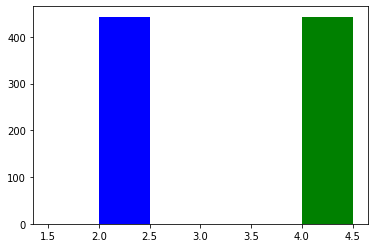

Percentage of 2 and 4 are:  50.0 % and  50.0 %


In [30]:
# TODO: 1st attempt: augment training data and go on with classification

oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X,Y)

checkClassBalance(Y_train)

# TRY UNDERSAMPLE BC OVERSAMPLE OVERFITS

<p><u>K-NN</u></p>

In [31]:
# array of possible K to apply KNN neighbors
ks = [3,5,7,9]

for k in ks:
    n_neighbors = k
    
    # Create an instance of neighbors classifier (clf) and fit the data
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    
    # train the classifier on the training set
    clf.fit(X_train, Y_train)
    
    print("Accuracy score on the test set with K =",n_neighbors,"is %.3f" %(clf.score(X_test, Y_test)))


    

Accuracy score on the test set with K = 3 is 0.982
Accuracy score on the test set with K = 5 is 0.982
Accuracy score on the test set with K = 7 is 0.982
Accuracy score on the test set with K = 9 is 0.982


<p><u>Logistic Regression</u><p>

In [32]:
logReg = LogisticRegression(solver="lbfgs", max_iter=2000) # instance of the model

logReg.fit(X_train, Y_train)

# res = logReg.predict(X_test)

print("Accuracy: ", logReg.score(X_test, Y_test))
print(classification_report(Y_test, logReg.predict(X_test)))

Accuracy:  0.9766081871345029
              precision    recall  f1-score   support

           2       0.98      0.98      0.98       109
           4       0.97      0.97      0.97        62

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



<p><u> Random forest</u> </p>

In [33]:
rndFor = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rndFor.fit(X_train, Y_train)

y_pred = rndFor.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, rndFor.predict(X_test)))

Accuracy:  1.0
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       109
           4       1.00      1.00      1.00        62

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



<p><u> SVM</u> </p>

In [34]:
svc = SVC(gamma='auto', kernel='rbf')
svc.fit(X_train, Y_train)
print(classification_report(Y_test, svc.predict(X_test)),"\n")

              precision    recall  f1-score   support

           2       1.00      0.98      0.99       109
           4       0.97      1.00      0.98        62

    accuracy                           0.99       171
   macro avg       0.98      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171
 



<p> So this is the accuracy with the default parameters, but with SVM approach is necessary to perform some parameters tuning in order to achieve a better result. To do so I relied on the GridSearch <p>
<p><u> SVM with GridSearch </u></p>

In [35]:
parameters = [{'C': [0.1, 0.2, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.25, 1], 'kernel': ['rbf', 'poly', 'sigmoid']}]
svcGS = GridSearchCV(SVC(), parameters, n_jobs=-1, cv=10)
svcGS.fit(X_train, Y_train)

print(classification_report(Y_test, svcGS.predict(X_test)),"\n")

print("Confusion Matrix")
print(metrics.confusion_matrix(Y_test, svcGS.predict(X_test)))

              precision    recall  f1-score   support

           2       1.00      0.97      0.99       109
           4       0.95      1.00      0.98        62

    accuracy                           0.98       171
   macro avg       0.98      0.99      0.98       171
weighted avg       0.98      0.98      0.98       171
 

Confusion Matrix
[[106   3]
 [  0  62]]


<p> The result above shows us a fuller report. </p>